## 作業
請詳細閱讀 https://github.com/qqwweee/keras-yolo3 的 readme ，按照 readme 的說明嘗試修改程式碼範例，學會使用 tiny YOLOv3 來做檢測，並且計算其平均 fps 以及觀察其檢測結果。


In [124]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.0


In [125]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive'
/content/gdrive/My Drive/keras-yolo3
[Errno 2] No such file or directory: 'keras-yolo3'
/content/gdrive/My Drive/keras-yolo3


In [126]:
import os
import subprocess
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [0]:
# 下載圖片範例，如果已經下載過就可以註解掉
# !wget https://github.com/pjreddie/darknet/blob/master/data/dog.jpg?raw=true -O dog.jpg
# !wget https://github.com/pjreddie/darknet/blob/master/data/horses.jpg?raw=true -O horses.jpg

In [0]:
from PIL import Image

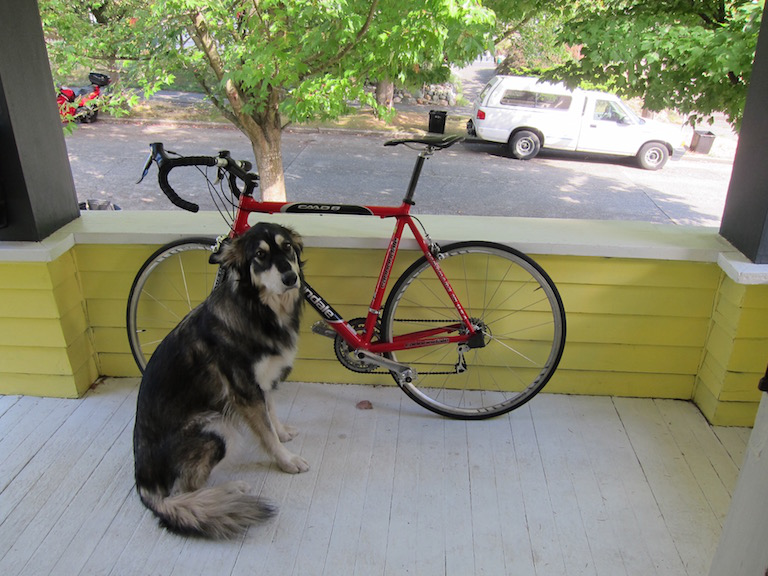

In [129]:
image = Image.open('dog.jpg') # 讀取範例圖片
image

In [0]:
# 將 yolo.py 所需要的套件載入
import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

In [0]:
# 定義 YOLO class
class YOLO(object):
    _defaults = {
        "model_path": 'model_data/yolo.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/coco_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes
    
    # 更改 detect_image 使得其回傳需要的信息
    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        # return out_boxes, out_scores, out_classes
        return image

    def close_session(self):
        self.sess.close()

    # 單純 inference 的 method
    def pure_detect_image(self, image):
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        # print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        return out_boxes, out_scores, out_classes

In [132]:
yolo = YOLO() # 初始化 YOLO class

model_data/yolo.h5 model, anchors, and classes loaded.


In [0]:
import numpy as np
import time

In [134]:
start = time.time()
results = yolo.pure_detect_image(image)
end = time.time()
print("single inference took: %.3fs" % (end-start))

single inference took: 9.178s


In [135]:
print(zip(results))

In [136]:
fps = 1 / (end-start)
print("fps: %.3f" % (fps))

fps: 0.109


In [0]:
time_eplased = []
for i in range(100):
  start = time.time()
  results = yolo.pure_detect_image(image)
  end = time.time()
  time_eplased.append(end-start)

In [138]:
avg_fps = 1/np.mean(time_eplased)
print("avg fps: %.3f" % avg_fps)

avg fps: 13.822


In [139]:
!nvidia-smi # 可用來檢測使用什麼 GPU, 在這裡是 Tesla K80

Sat Feb 15 06:44:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    25W /  75W |   7513MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

**作業**

請詳細閱讀 https://github.com/qqwweee/keras-yolo3 的 readme ，按照 readme 的說明嘗試修改程式碼範例，學會使用 tiny YOLOv3 來做檢測，並且計算其平均 fps 以及觀察其檢測結果。

In [0]:
# !wget https://pjreddie.com/media/files/yolov3.weights

In [0]:
unit_test = True

In [142]:
import os
def check_yolo_tiny_weight():
    if not os.path.exists("convert.py") and not os.path.exists("yolov3-tiny.cfg"):
        print('May not in correct keras-yolo path...')
        return False

    if not os.path.exists("model_data/yolov3-tiny.h5"):
        if not os.path.exists("yolov3-tiny.weights"):
            print("Model doesn't exist, downloading...")
            os.system("wget https://pjreddie.com/media/files/yolov3-tiny.weights")
        os.system("python convert.py yolov3-tiny.cfg yolov3-tiny.weights model_data/yolov3-tiny.h5")
        print("Converting yolov3-tiny.weights to yolo-tiny.h5...")
    else:
        print('model is existed.')

    return True

if unit_test:
    check_yolo_tiny_weight()


model is existed.


In [0]:
# init yolo config
yolo_model_path = "model_data/yolov3-tiny.h5"
yolo_anchor_path = "model_data/tiny_yolo_anchors.txt"

yolo_config = {
    "model_path": yolo_model_path,
    "anchors_path" : yolo_anchor_path 
}

def init_yolo_model(yolo_config):
    yolo_model = YOLO(**yolo_config)
    return yolo_model
    

In [0]:
video_path = "Office-Parkour.mp4"

def fetch_frames_from_video():
    frame_limit_count = 9
    current_count = 0
    # frame_interval = 2
    frame_interval = 30
    frame_ind = 251

    v_ptr = cv2.VideoCapture(video_path)
    if not v_ptr.isOpened():
        raise IOError("Couldn't open video")

    frame_list = list()
    while current_count < frame_limit_count:
        v_ptr.set(cv2.CAP_PROP_POS_FRAMES, frame_ind)
        rlt, frame = v_ptr.read()
        if not rlt:
            print('fail read at index:{}'.format(frame_ind))
            raise IOError("Couldn't read frame")
        
        frame_img = Image.fromarray(frame)
        frame_list.append(frame_img)
        current_count += 1
        frame_ind += frame_interval
        
    # print(frame_list[0])
    # print(frame_list[0].shape)
    # print(len(frame_list))
    return frame_list

if unit_test:
    fetch_frames_from_video()


In [0]:

def predict_images(model, images):
    detect_imgs = list()
    time_elapsed = list()
    
    for img in images:
        start_time = time.time()
        detect_img = model.detect_image(img)
        print(type(detect_img))
        detect_imgs.append(detect_img)
        time_elapsed.append(time.time()-start_time)
    
    avg_fps = 1/np.mean(time_elapsed)
    print('avg_fps = %3f' % avg_fps)
    return detect_imgs
    

In [0]:
import matplotlib.pyplot as plt

def show_images(images):
    plt.figure(figsize=(20,20))
    for img_idx, tmp_img in enumerate(images):
        print(type(tmp_img))
        
        tmp_img = np.asarray(tmp_img)
        tmp_img = tmp_img[:,:,::-1]
        print(tmp_img.shape)
        plt.subplot(331+img_idx)
        plt.imshow(tmp_img)

    plt.tight_layout()
    plt.show()
    pass

unit_test = False
if unit_test:
    test_images = list()
    dog_img = Image.open('dog.jpg')
    test_images.append(dog_img)
    show_images(test_images)
    

model is existed.
model_data/yolov3-tiny.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 4 boxes for img
chair 0.35 (1063, 323) (1268, 655)
person 0.33 (290, 230) (641, 699)
person 0.40 (319, 66) (492, 392)
person 0.66 (1128, 27) (1274, 538)
8.89159308500166
<class 'PIL.Image.Image'>
(416, 416, 3)
Found 3 boxes for img
chair 0.33 (1040, 439) (1261, 702)
person 0.67 (95, 152) (602, 719)
person 0.74 (1020, 55) (1269, 647)
0.03668245199878584
<class 'PIL.Image.Image'>
(416, 416, 3)
Found 0 boxes for img
0.031895805997919524
<class 'PIL.Image.Image'>
(416, 416, 3)
Found 0 boxes for img
0.031170754999038763
<class 'PIL.Image.Image'>
(416, 416, 3)
Found 1 boxes for img
person 0.81 (548, 0) (956, 583)
0.033488920002128
<class 'PIL.Image.Image'>
(416, 416, 3)
Found 2 boxes for img
tie 0.52 (473, 337) (559, 640)
person 0.67 (115, 9) (1137, 689)
0.035182546998839825
<class 'PIL.Image.Image'>
(416, 416, 3)
Found 3 boxes for img
laptop 0.85 (671, 351) (1234, 707)
tie 0.71 (320, 318) (40

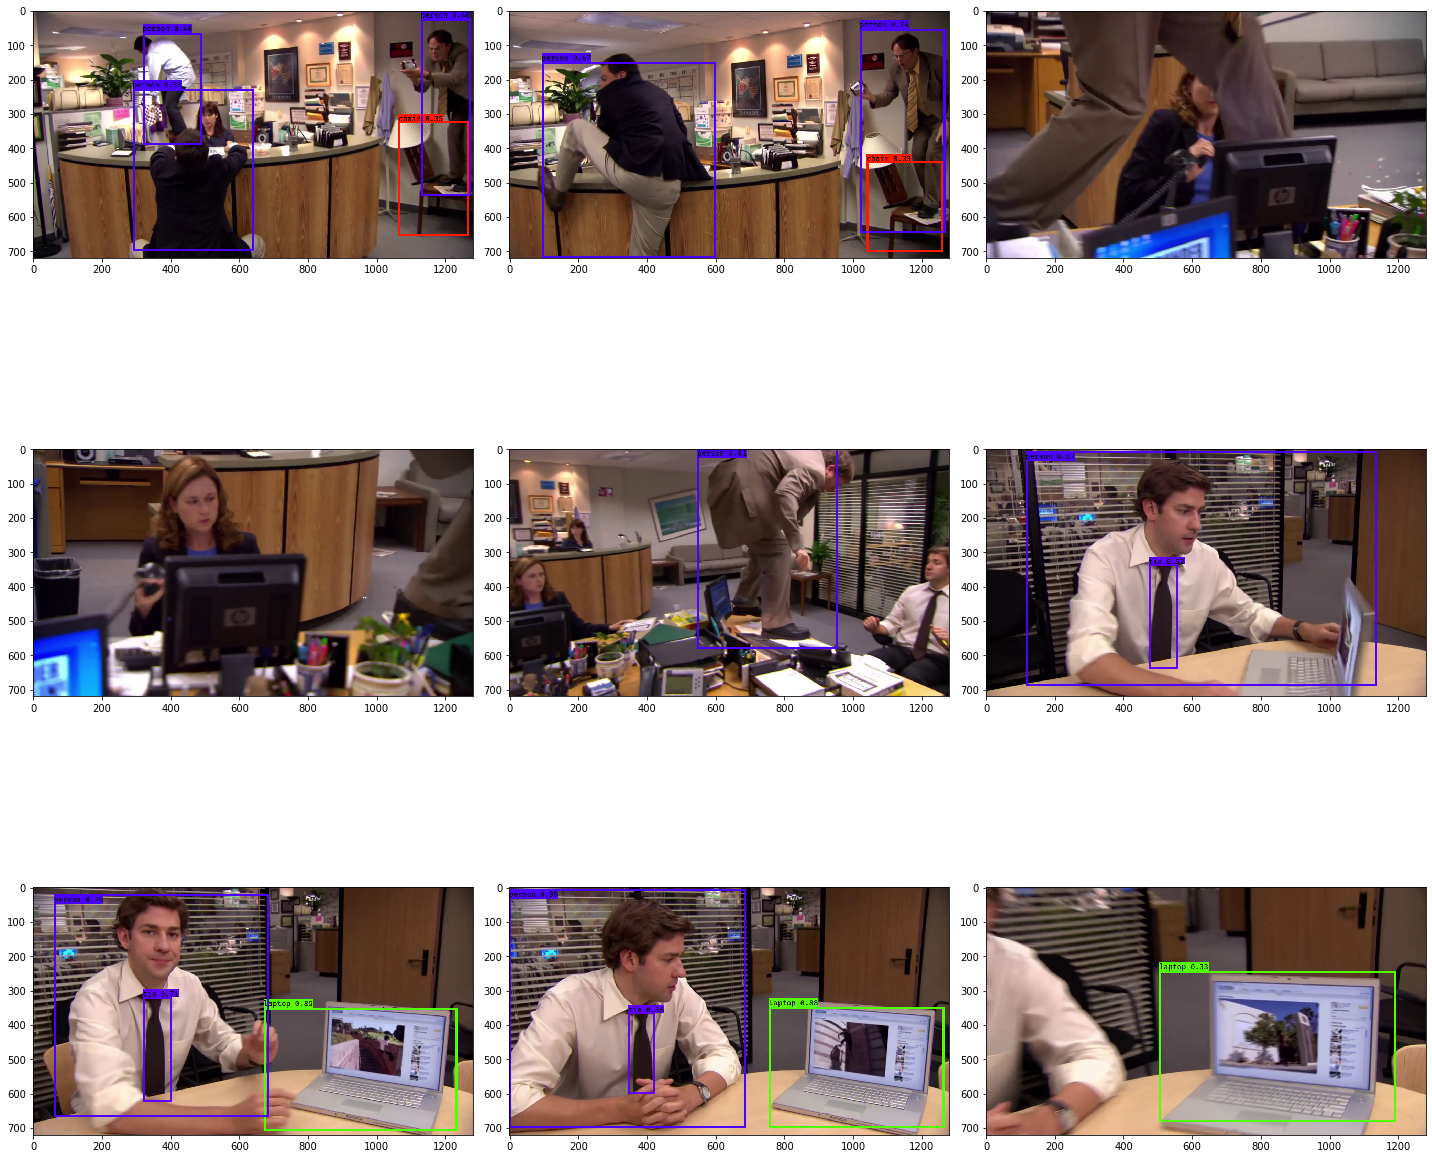

In [147]:
def yolo_tiny_main():
    # download weight
    if not check_yolo_tiny_weight():
        return
    
    # init model
    yolo_model = init_yolo_model(yolo_config)

    # fetch some image frame from video
    img_list = fetch_frames_from_video()

    # predict
    imgs = predict_images(yolo_model, img_list)

    # list all result images
    show_images(imgs)


yolo_tiny_main()